In [1]:
from memflow.read_data.dataset_all import DatasetCombined
from memflow.unfolding_network.conditional_transformer import ConditioningTransformerLayer
from memflow.unfolding_flow.utils import *

import numpy as np
import scipy.stats as st
import torch
from torch import optim
from torch.utils.data import DataLoader
import torch.nn as nn
from torch.nn.functional import normalize
from torch.optim.lr_scheduler import CosineAnnealingLR

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib as mpl
from matplotlib import cm

from tensorboardX import SummaryWriter
from omegaconf import OmegaConf
import sys
import argparse
import os
from pynvml import *
from hist import Hist
import hist
import vector
import mplhep
import awkward as ak

from memflow.read_data.utils import to_flat_tensor
from memflow.phasespace.phasespace import PhaseSpace

from utils import FindMasks
from utils import SavePlots
from utils import plot_regressionFactor
from scipy.interpolate import griddata
from mpl_toolkits.mplot3d import axes3d, Axes3D #<-- Note the capitalization! 

pi = torch.pi

In [2]:
batchSize = 1024
path_data = '/eos/user/d/dvalsecc/www/ttHbbAnalysis/training_dataset/v3_sig_forTrainingDataset/all_jets_fullRun2_ttHbb_forTraining_allyears_spanetprov_part1.parquet'
device = torch.device('cpu')

data = DatasetCombined(path_data, dev=device, dtype=torch.float64,
                        reco_list=['data_boost'],
                        parton_list=['data_higgs_t_tbar_ISR',
                                    'phasespace_intermediateParticles',
                                    'phasespace_rambo_detjacobian'])

dataCorrect = data.parton_data.data_higgs_t_tbar_ISR


RecoLevel
Reading reco_level Files

PartonLevel
Reading parton_level Files
Load phasespace_intermediateParticles
Load phasespace_rambo_detjacobian



In [3]:
print(dataCorrect.shape)
higgs = dataCorrect[:,0].detach().numpy()
t = dataCorrect[:,1].detach().numpy()
tbar = dataCorrect[:,2].detach().numpy()
ISR = dataCorrect[:,3].detach().numpy()

# "H_thad_tlep_ISR": ["pt", "eta", "phi", "mass"]

torch.Size([1194750, 4, 4])


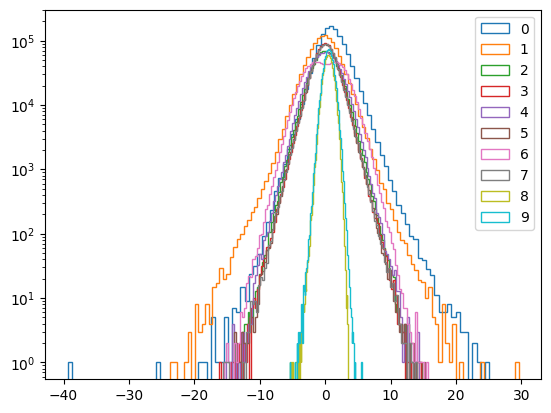

In [10]:
PS = data.parton_data.phasespace_intermediateParticles

for i in range(10):
    plt.hist(torch.logit(PS[:,i]).detach().numpy(), bins=100, label=f"{i}", histtype="step")
plt.yscale("log")
plt.legend()
plt.show()


In [5]:
def plot_var2d(higgs_var1, higgs_var2, name1, name2, nameFig, start1=0, stop1=1000,
               start2=0, stop2=1000, bins1=100, bins2=100, title='',
               log=False, axis1='da', axis2='da'):

        # Quick construction, no other imports needed:
        hist2d_var_higgs = (
          Hist.new
          .Reg(bins=bins1, start=start1, stop=stop1, name=name1, label=name1)
          .Reg(bins=bins2, start=start2, stop=stop2, name=name2, label=name2)
          .Double())

        hist2d_var_higgs.fill(higgs_var1,
                            higgs_var2)

        colormap='viridis'
        my_viridis = mpl.colormaps[colormap].with_extremes(under="white")
        
        fontsize = 20
        labelsize=14
        hist2d_list = [hist2d_var_higgs]
        
        fig, axs = plt.subplots(1, 2, figsize=(16, 6))
        i = 0

        if log:
            w, x, y = hist2d_list[i].to_numpy()
            mesh = axs[i].pcolormesh(x, y, w.T, cmap=my_viridis, norm=mpl.colors.LogNorm(vmin=1))
            axs[i].set_xlabel(f"{axis1}", fontsize=fontsize)
            axs[i].set_ylabel(f"{axis2}", fontsize=fontsize)
            axs[i].set_title(f"{title}", fontsize=fontsize)
            axs[i].tick_params(axis='both', which='major', labelsize=labelsize)
            cbar = fig.colorbar(mesh)
            cbar.ax.tick_params(labelsize=labelsize)
            plt.tight_layout()

        else:
            w, x, y = hist2d_list[i].to_numpy()
            mesh = axs[i].pcolormesh(x, y, w.T, cmap=my_viridis, vmin=1)
            axs[i].set_xlabel(f"{axis1}", fontsize=fontsize)
            axs[i].set_ylabel(f"{axis2}", fontsize=fontsize)
            axs[i].set_title(f"{labels[i]}", fontsize=fontsize)
            axs[i].tick_params(axis='both', which='major', labelsize=labelsize)
            cbar = fig.colorbar(mesh)
            cbar.ax.tick_params(labelsize=labelsize)
            plt.tight_layout()

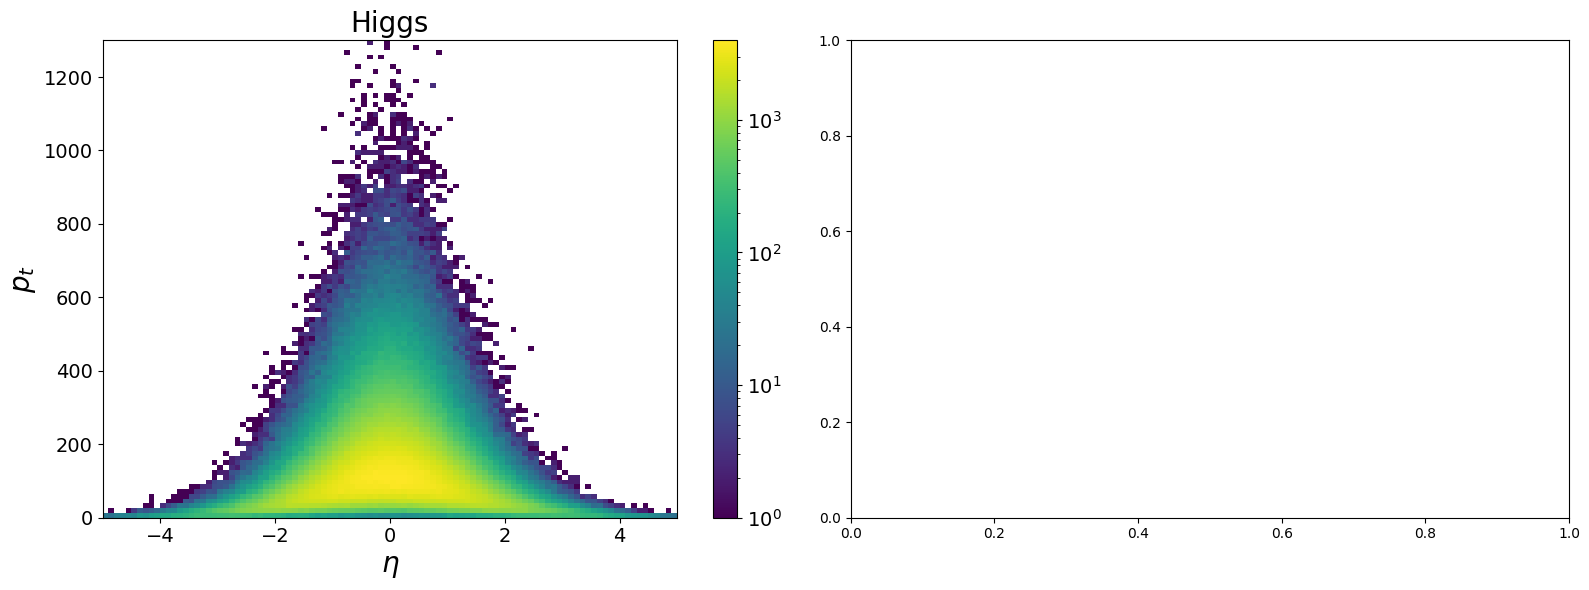

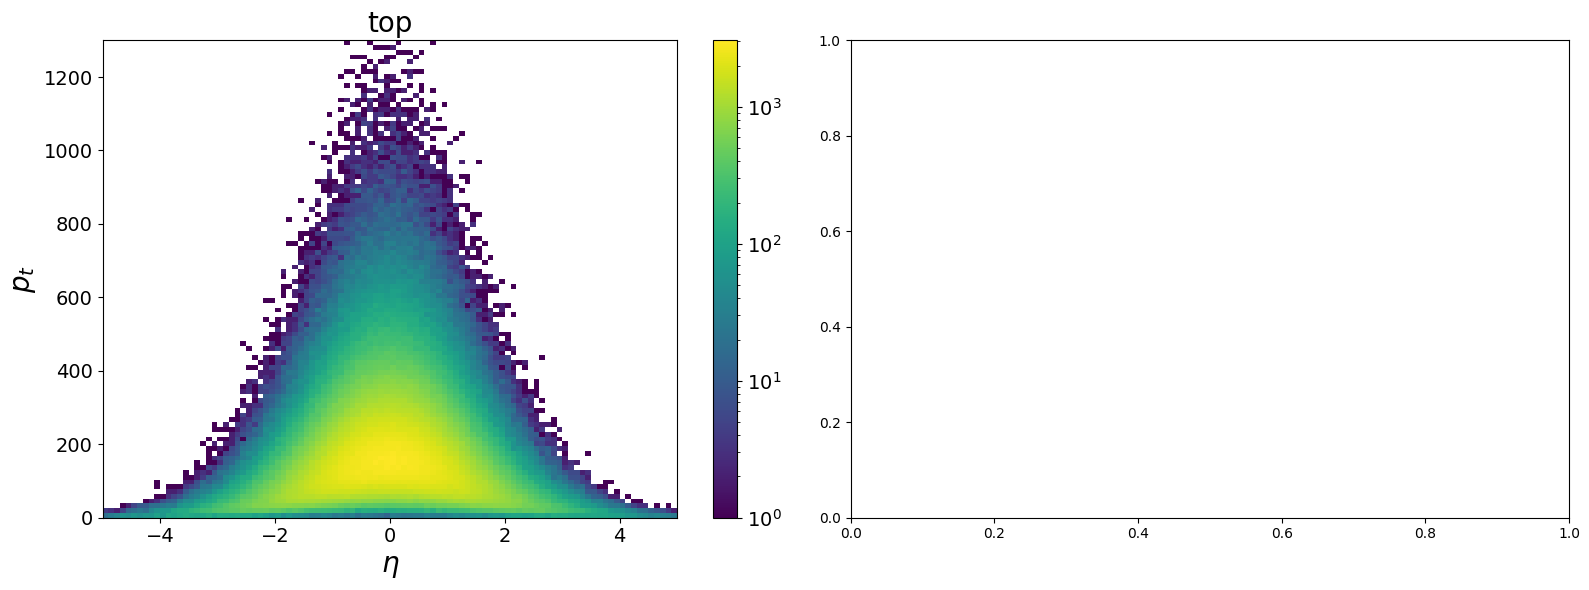

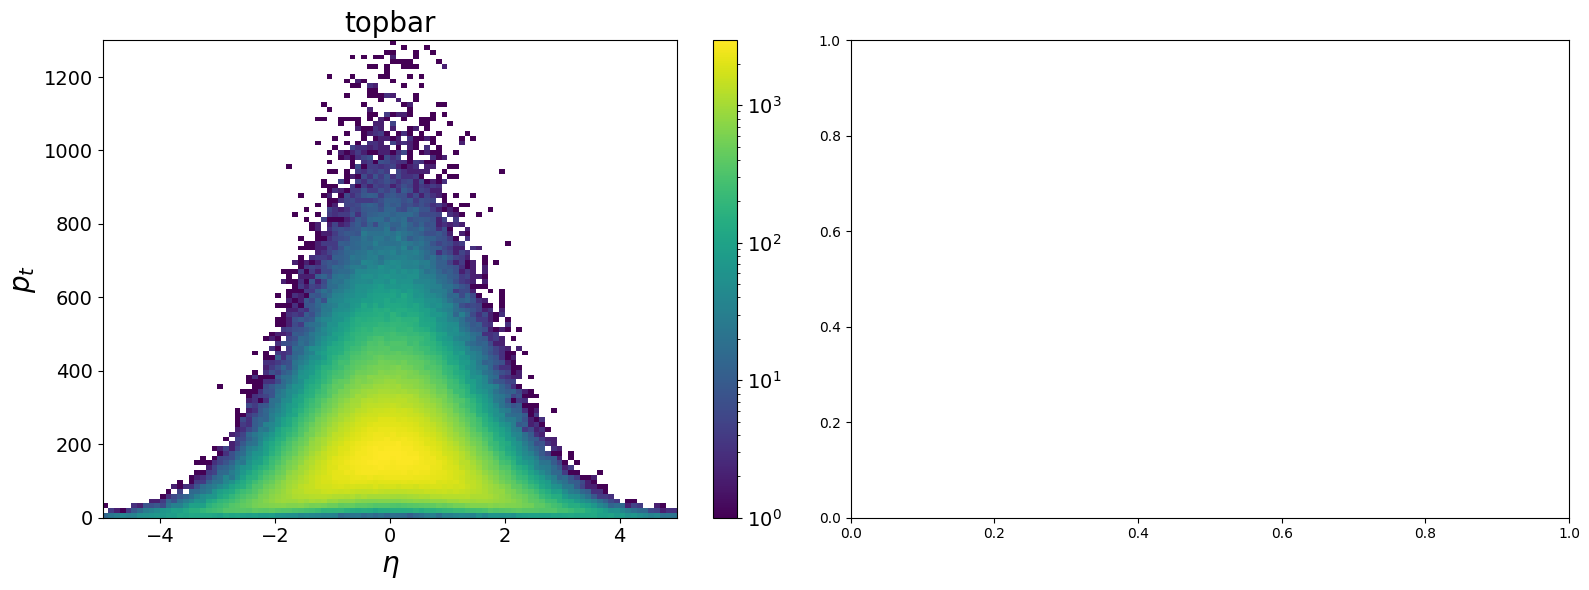

In [6]:
plot_var2d(higgs_var1=higgs[:,1], higgs_var2=higgs[:,0],
           name1='$eta$', name2='$p_t (GeV)$', nameFig='29.png', title='Higgs',
           start1=-5, stop1=5, start2=0, stop2=1300, bins1=100, bins2=100,
           log=True, axis1='$\eta$', axis2='$p_t$')

plot_var2d(higgs_var1=t[:,1], higgs_var2=t[:,0],
           name1='$eta$', name2='$p_t (GeV)$', nameFig='29.png', title='top',
           start1=-5, stop1=5, start2=0, stop2=1300, bins1=100, bins2=100,
           log=True, axis1='$\eta$', axis2='$p_t$')

plot_var2d(higgs_var1=tbar[:,1], higgs_var2=tbar[:,0],
           name1='$eta$', name2='$p_t (GeV)$', nameFig='29.png', title='topbar',
           start1=-5, stop1=5, start2=0, stop2=1300, bins1=100, bins2=100,
           log=True, axis1='$\eta$', axis2='$p_t$')

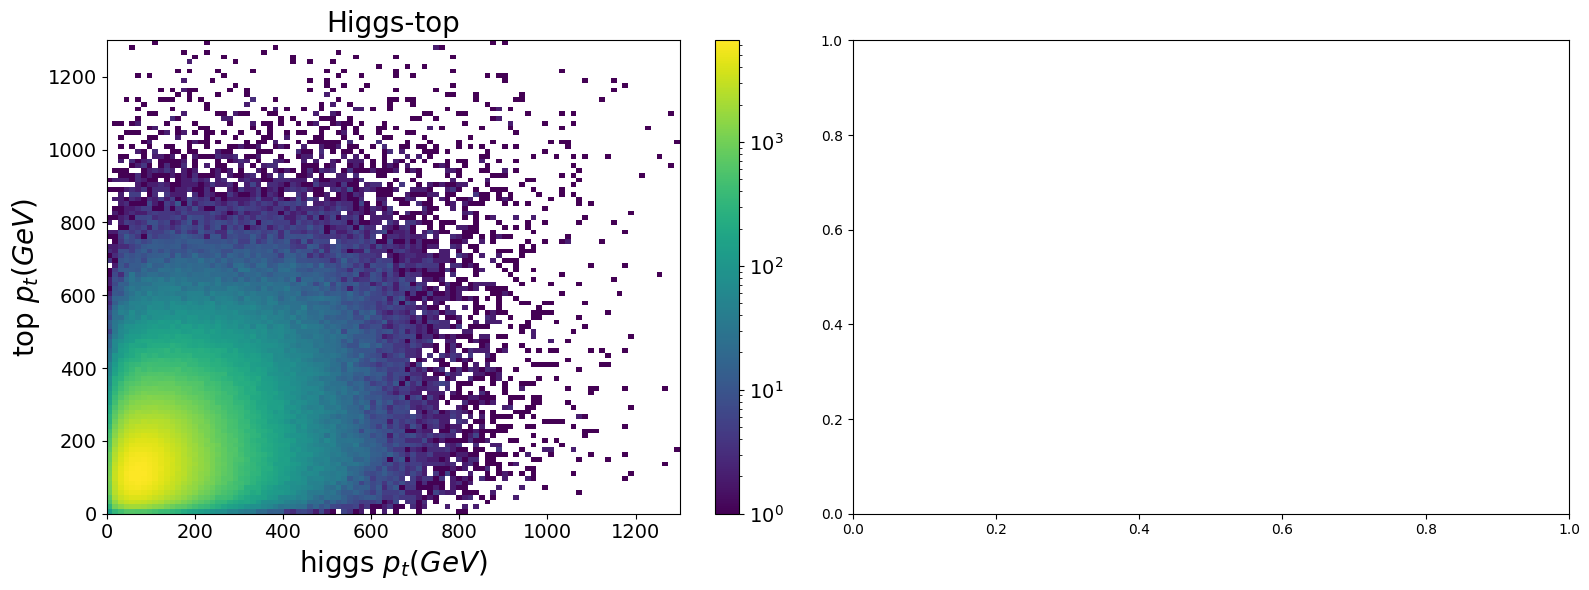

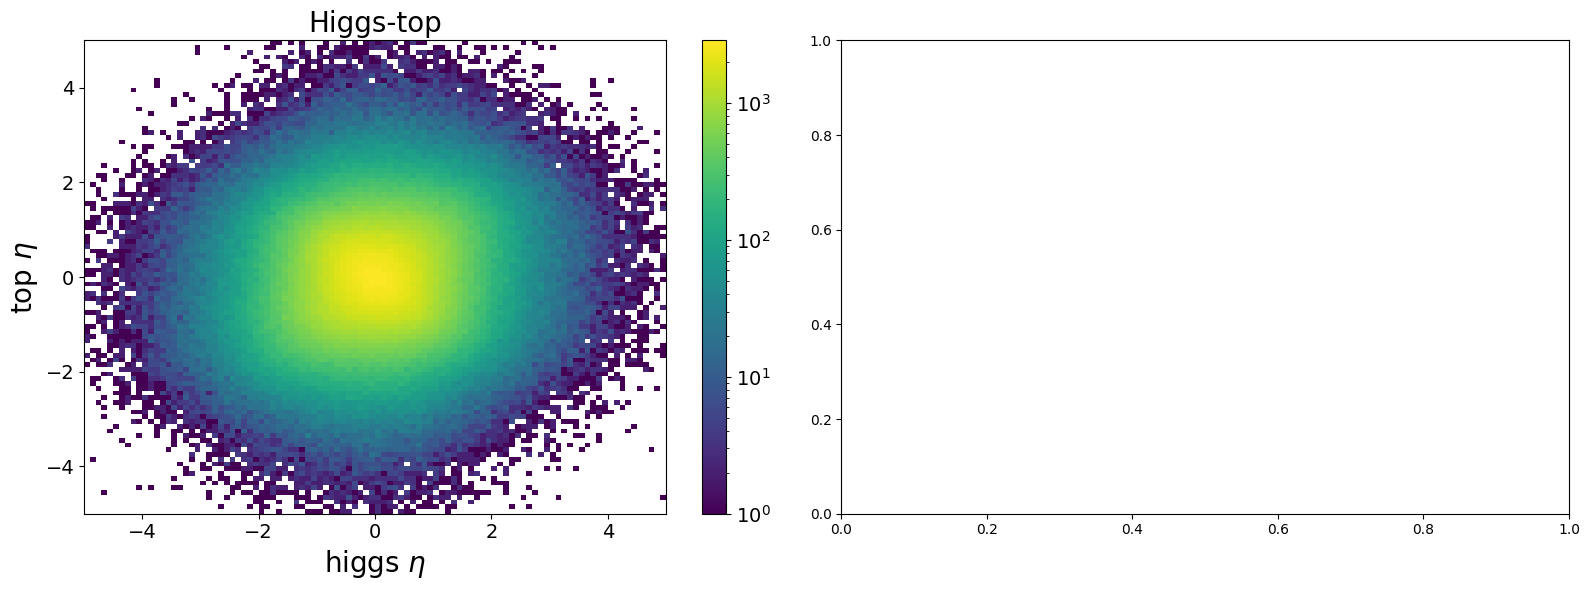

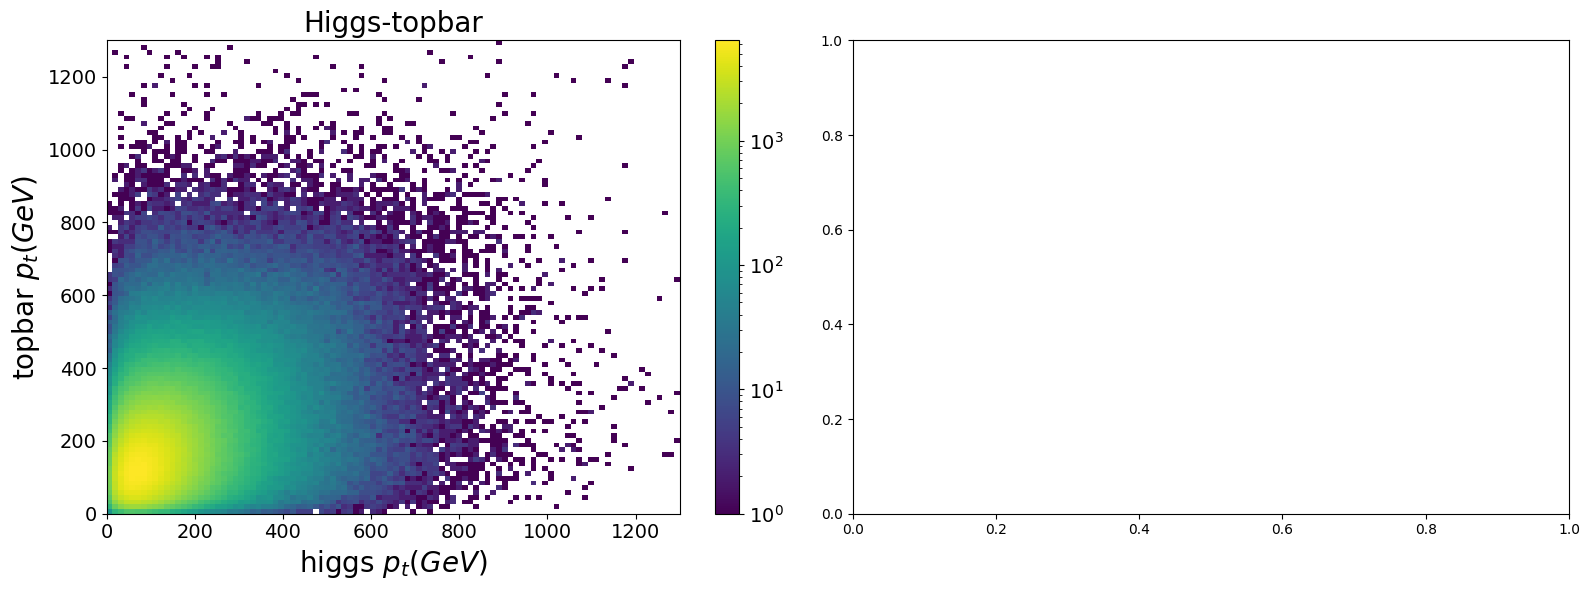

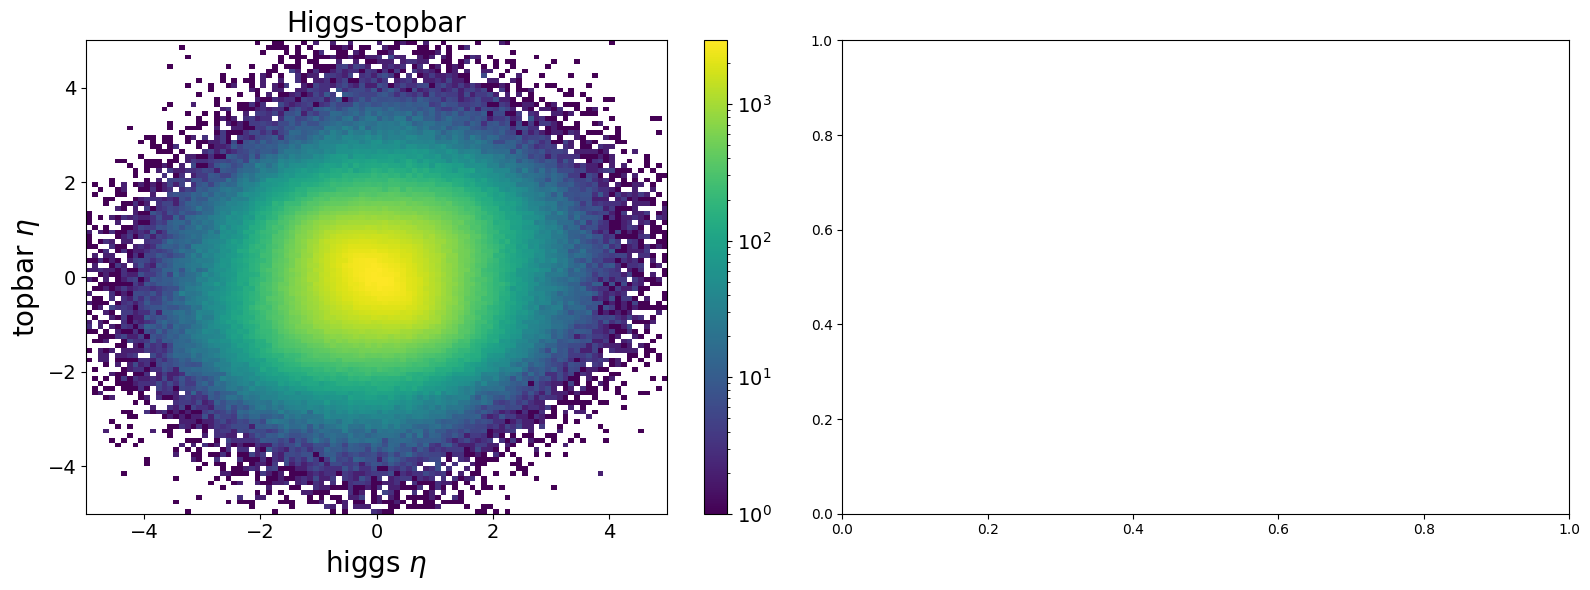

In [7]:
plot_var2d(higgs_var1=higgs[:,0], higgs_var2=t[:,0],
           name1='$p_t (GeV)$', name2='$p_t2 (GeV)$', nameFig='29.png', title='Higgs-top',
           start1=0, stop1=1300, start2=0, stop2=1300, bins1=100, bins2=100,
           log=True, axis1='higgs $p_t (GeV)$', axis2='top $p_t (GeV)$')

plot_var2d(higgs_var1=higgs[:,1], higgs_var2=t[:,1],
           name1='$\eta$', name2='$\eta2$', nameFig='29.png', title='Higgs-top',
           start1=-5, stop1=5, start2=-5, stop2=5, bins1=100, bins2=100,
           log=True, axis1='higgs $\eta$', axis2='top $\eta$')

plot_var2d(higgs_var1=higgs[:,0], higgs_var2=tbar[:,0],
           name1='$p_t (GeV)$', name2='$p_t2 (GeV)$', nameFig='29.png', title='Higgs-topbar',
           start1=0, stop1=1300, start2=0, stop2=1300, bins1=100, bins2=100,
           log=True, axis1='higgs $p_t (GeV)$', axis2='topbar $p_t (GeV)$')

plot_var2d(higgs_var1=higgs[:,1], higgs_var2=tbar[:,1],
           name1='$\eta$', name2='$\eta2$', nameFig='29.png', title='Higgs-topbar',
           start1=-5, stop1=5, start2=-5, stop2=5, bins1=100, bins2=100,
           log=True, axis1='higgs $\eta$', axis2='topbar $\eta$')

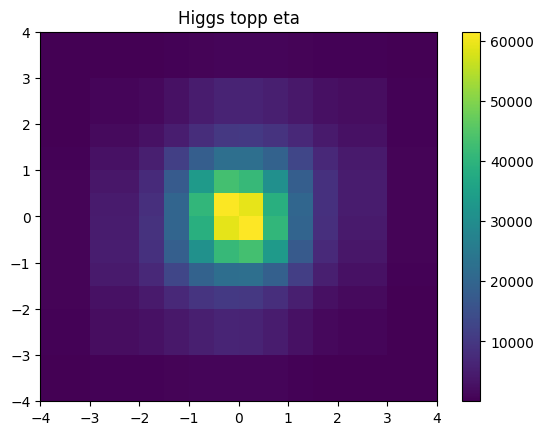

In [8]:
bins = [-4,-3,-2,-1.5,-1,-0.5,0,0.5,1,1.5,2,3,4]

h,_, _, image = plt.hist2d(higgs[:,1], t[:,1],
               bins=[bins, bins], cmin=1)
plt.colorbar(image)
plt.title('Higgs topp eta')
plt.show()

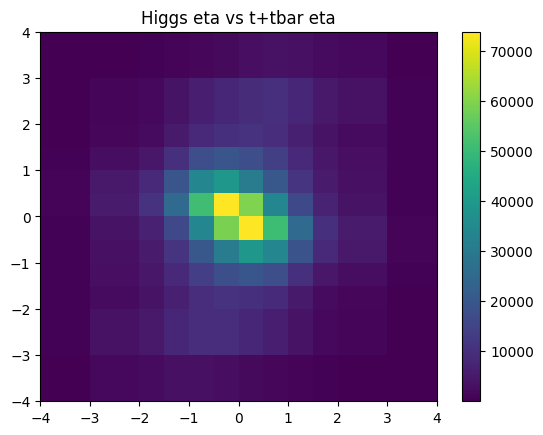

In [16]:
bins = [-4,-3,-2,-1.5,-1,-0.5,0,0.5,1,1.5,2,3,4]

h,_, _, image = plt.hist2d(higgs[:,1], t[:,1]+tbar[:,1],
               bins=[bins, bins], cmin=1)
plt.colorbar(image)
plt.title('Higgs eta vs t+tbar eta')
plt.show()

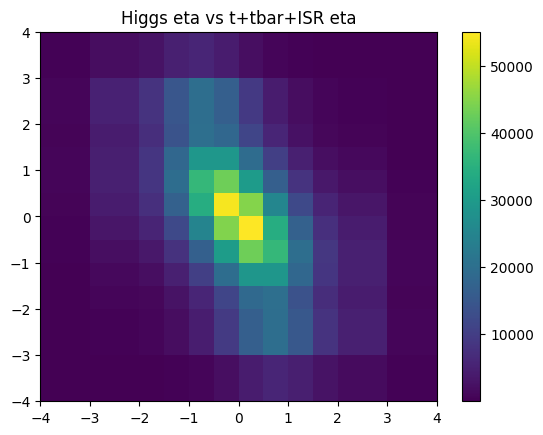

In [17]:
bins = [-4,-3,-2,-1.5,-1,-0.5,0,0.5,1,1.5,2,3,4]

h,_, _, image = plt.hist2d(higgs[:,1], t[:,1]+tbar[:,1] + ISR[:,1],
               bins=[bins, bins], cmin=1)
plt.colorbar(image)
plt.title('Higgs eta vs t+tbar+ISR eta')
plt.show()

# 3d HISTOGRAM with 1D weights

In [26]:
bins = [-8,-3,-2,-1.5,-1,-0.5,0,0.5,1,1.5,2,3,8]

#print(len(higgs[:,1]))

weights_events_higgs = np.zeros(len(higgs[:,1]))
weights_events_t = np.zeros(len(t[:,1]))
weights_events_tbar = np.zeros(len(tbar[:,1]))

for i in range(12):
    mask1 = higgs[:,1] >= bins[i]
    mask2 = higgs[:,1] < bins[i+1]
    mask = np.logical_and(mask1, mask2)
    counts = np.count_nonzero(mask)
    weights_events_higgs[mask] = len(weights_events_higgs)/counts
    
    mask1 = t[:,1] >= bins[i]
    mask2 = t[:,1] < bins[i+1]
    mask = np.logical_and(mask1, mask2)
    counts = np.count_nonzero(mask)
    weights_events_t[mask] = len(weights_events_higgs)/counts
    
    mask1 = tbar[:,1] >= bins[i]
    mask2 = tbar[:,1] < bins[i+1]
    mask = np.logical_and(mask1, mask2)
    counts = np.count_nonzero(mask)
    weights_events_tbar[mask] = len(weights_events_higgs)/counts

In [27]:
weight = weights_events_higgs*weights_events_t*weights_events_tbar

In [28]:
def get_weights(eta, bins):
    x = np.digitize(eta, bins=bins)
    y = np.bincount(x)
    z = len(eta)/y[x]
    return z

In [29]:
w_h = get_weights(higgs[:,1], bins)
w_t = get_weights(t[:,1], bins)
w_tbar = get_weights(tbar[:,1], bins)

print((w_h == weights_events_higgs).all())
print((w_t == weights_events_t).all())
print((w_tbar == weights_events_tbar).all())

True
True
True


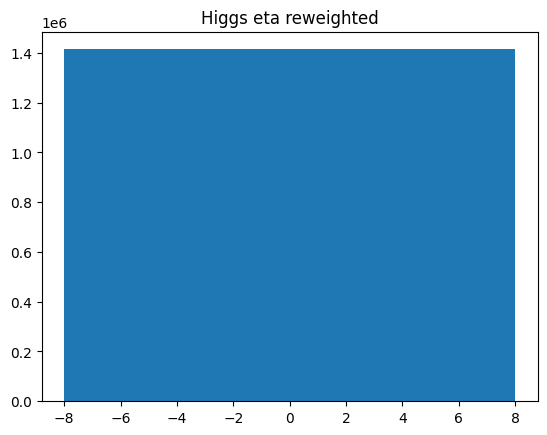

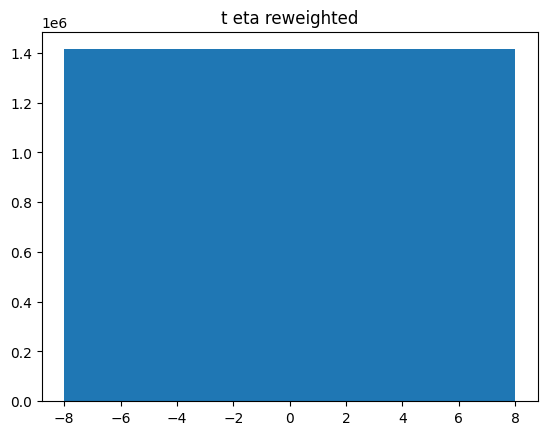

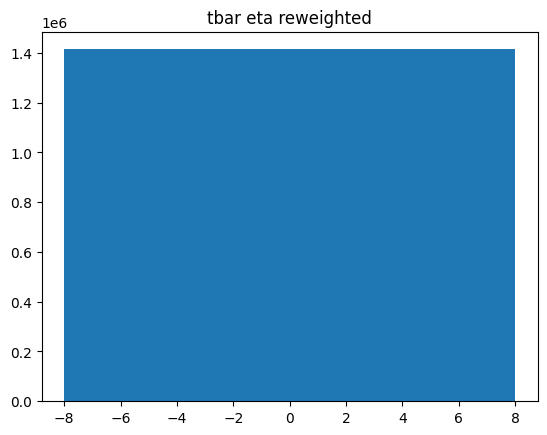

In [30]:
x = plt.hist(higgs[:,1], bins=bins, weights=weights_events_higgs)
plt.title('Higgs eta reweighted')
plt.show()

x = plt.hist(t[:,1], bins=bins, weights=weights_events_t)
plt.title('t eta reweighted')
plt.show()

x = plt.hist(tbar[:,1], bins=bins, weights=weights_events_tbar)
plt.title('tbar eta reweighted')
plt.show()

In [31]:
np.max(weights_events_higgs)

255.99746560463433

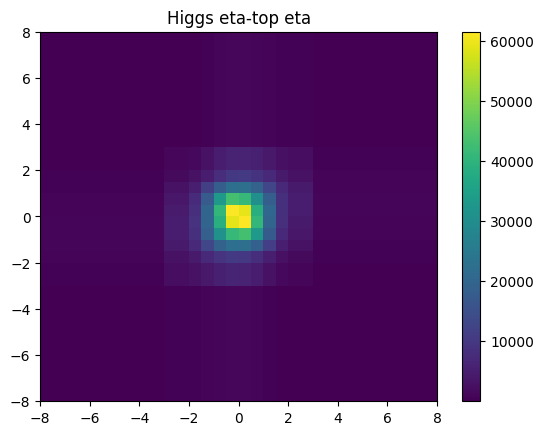

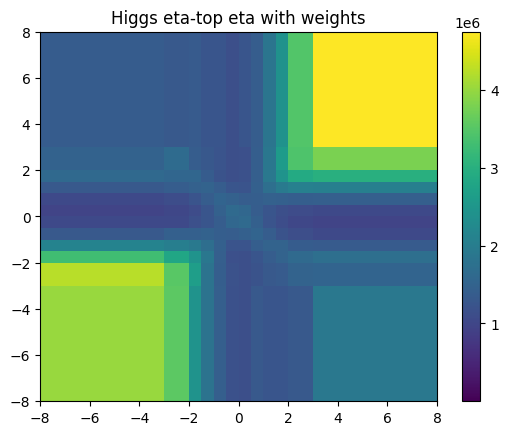

In [32]:
h,_, _, image = plt.hist2d(higgs[:,1], t[:,1],
               bins=[bins, bins], vmin=1)
plt.colorbar(image)
plt.title('Higgs eta-top eta')
plt.show()

h,_, _, image = plt.hist2d(higgs[:,1], t[:,1],
               bins=[bins, bins], weights=weights_events_higgs*weights_events_t, vmin=1)
plt.colorbar(image)
plt.title('Higgs eta-top eta with weights')
plt.show()

In [33]:
bins = [-8,-3,-2,-1.5,-1,-0.5,0,0.5,1,1.5,2,3,8]
bins = [-3,-2,-1.5,-1,-0.5,0,0.5,1,1.5,2,3]
bins = [-2,-1.5,-1,-0.5,0,0.5,1,1.5,2]
bins = [-1.5,-1,-0.5,0,0.5,1,1.5]
print(len(bins))

h = Hist(
    hist.axis.Variable(bins, name="h"),
    hist.axis.Variable(bins, name="t"),
    hist.axis.Variable(bins, name="tbar"),
)

h.fill(higgs[:,1], t[:,1], tbar[:,1], weight=weights_events_higgs*weights_events_t*weights_events_tbar)

7


Hist(
  Variable([-1.5, -1, -0.5, 0, 0.5, 1, 1.5], name='h'),
  Variable([-1.5, -1, -0.5, 0, 0.5, 1, 1.5], name='t'),
  Variable([-1.5, -1, -0.5, 0, 0.5, 1, 1.5], name='tbar'),
  storage=Double()) # Sum: 312099405.4732295 (4378662442.406651 with flow)

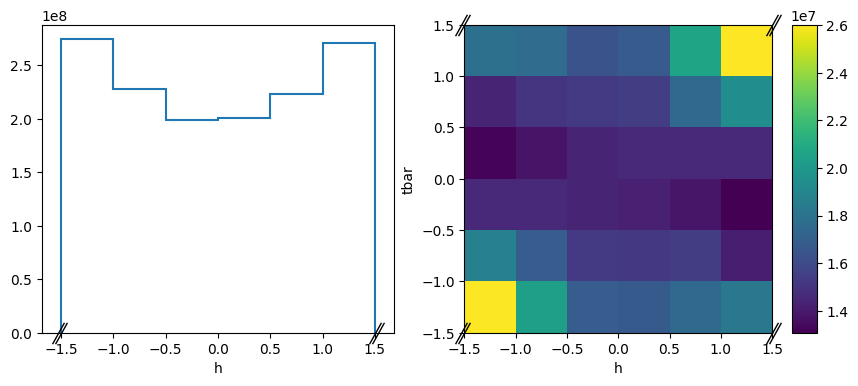

In [35]:
import matplotlib.pyplot as plt

# auto-plot
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

h.project("h").plot(ax=axs[0])
h.project("h", "tbar").plot(ax=axs[1])
plt.show()

In [13]:
mplhep.histplot(h[0])

IndexError: Wrong number of indices for histogram

In [ ]:
hist, bin_edges = np.histogram(a, density=True)

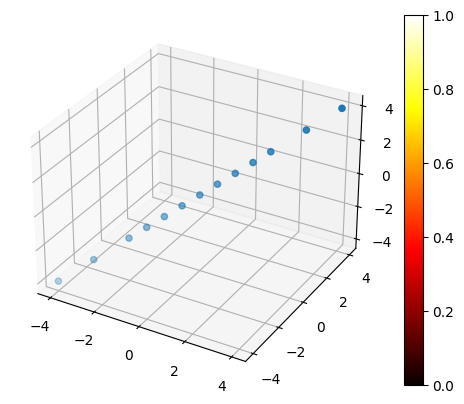

In [89]:
w, x, y, z = h.to_numpy()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

c = w.flatten()

img = ax.scatter(x, y, z, cmap=plt.hot())
fig.colorbar(img)
plt.show()

In [ ]:
for i in range

# reweight eta

Text(0.5, 1.0, 'Higgs pt')

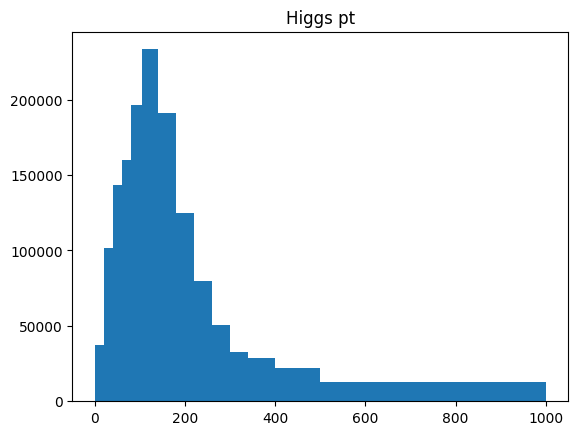

In [48]:
x = plt.hist(higgs[:,0], bins=[0,20,40,60,80,105,140,180,220,260,300,340,400,500,1000])
plt.title('Higgs pt')

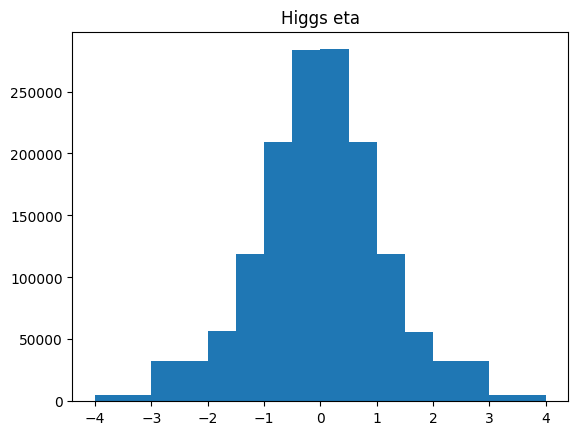

1414130


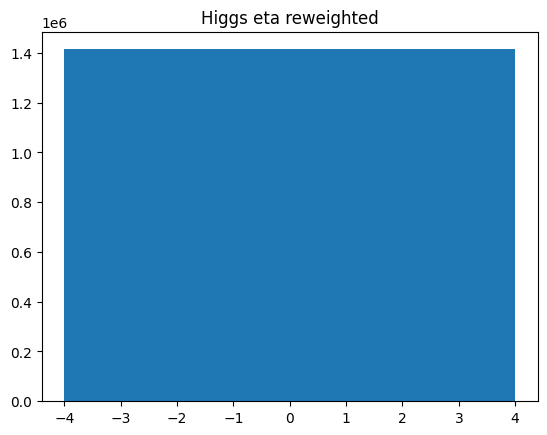

In [49]:
bins = [-4,-3,-2,-1.5,-1,-0.5,0,0.5,1,1.5,2,3,4]

x = plt.hist(higgs[:,1], bins=bins)
plt.title('Higgs eta')
plt.show()

print(len(higgs[:,1]))

weigths = []
weights_events = np.zeros(len(higgs[:,1]))

for i in range(12):
    mask1 = higgs[:,1] >= bins[i]
    mask2 = higgs[:,1] < bins[i+1]
    mask = np.logical_and(mask1, mask2)
    counts = np.count_nonzero(mask)
    weigths.append(counts/len(higgs[:,1]))
    weights_events[mask] = len(higgs[:,1])/counts
    
#print((weights_events == 0).any())

bins = [-4,-3,-2,-1.5,-1,-0.5,0,0.5,1,1.5,2,3,4]

x = plt.hist(higgs[:,1], bins=bins, weights=weights_events)
plt.title('Higgs eta reweighted')
plt.show()
    

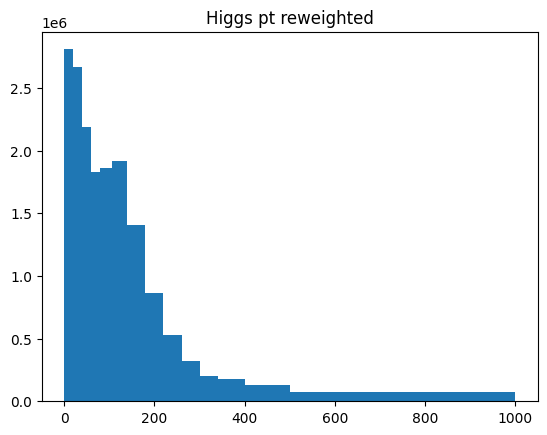

In [50]:
x = plt.hist(higgs[:,0], bins=[0,20,40,60,80,105,140,180,220,260,300,340,400,500,1000], weights=weights_events)
plt.title('Higgs pt reweighted')
plt.show()

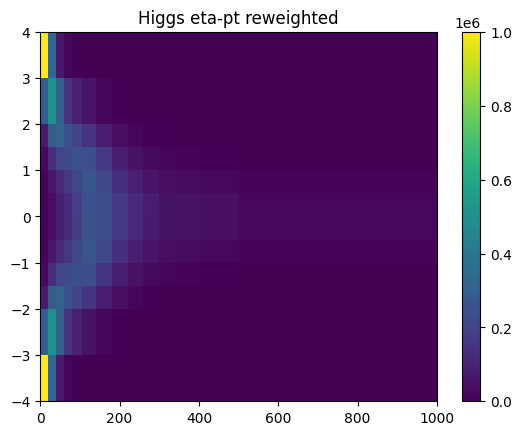

In [51]:
bins1=[-4,-3,-2,-1.5,-1,-0.5,0,0.5,1,1.5,2,3,4]
bins2=[0,20,40,60,80,105,140,180,220,260,300,340,400,500,1000]

#weights = np.resize(weights_events, )

h,_, _, image = plt.hist2d(higgs[:,0], higgs[:,1],
               bins=[bins2, bins1], weights=weights_events)
plt.colorbar(image)
plt.title('Higgs eta-pt reweighted')
plt.show()

In [14]:
batchSize = 1024
path_data = '../../dataset/v7/all_jets_fullRun2_v1.parquet'
device = torch.device('cpu')

path_unscaled = 'preTraining_7August/preTraining_noProv:True_cartesian:False_HuberLoss:True_latent_space:True_hiddenFeatures:64_dimFeedForward:1024_nheadEnc:8_LayersEnc:4_nheadDec:8_LayersDec:4/unscaledRegressedPartonsTensor.pt'
path_to_conf = 'preTraining_7August/preTraining_noProv:True_cartesian:False_HuberLoss:True_latent_space:True_hiddenFeatures:64_dimFeedForward:1024_nheadEnc:8_LayersEnc:4_nheadDec:8_LayersDec:4/config_preTraining-MEMFlow_noprov-eta_v00_v0.yaml'


with open(path_to_conf) as f:
        conf = OmegaConf.load(path_to_conf)

log_mean = torch.tensor(conf.scaling_params.log_mean, device=device)
log_std = torch.tensor(conf.scaling_params.log_std, device=device)

In [15]:
data = DatasetCombined(path_data, dev=device, dtype=torch.float64,
                        reco_list=['data_boost'],
                        parton_list=['data_higgs_t_tbar_ISR',
                                    'phasespace_intermediateParticles',
                                    'phasespace_rambo_detjacobian'])

dataCorrect = data.parton_data.data_higgs_t_tbar_ISR_cartesian

higgsCorrect = vector.array(
    {
        "E": dataCorrect[:,0,0].detach().numpy(),
        "px": dataCorrect[:,0,1].detach().numpy(),
        "py": dataCorrect[:,0,2].detach().numpy(),
        "pz": dataCorrect[:,0,3].detach().numpy(),
    }
)

thadCorrect = vector.array(
    {
        "E": dataCorrect[:,1,0].detach().numpy(),
        "px": dataCorrect[:,1,1].detach().numpy(),
        "py": dataCorrect[:,1,2].detach().numpy(),
        "pz": dataCorrect[:,1,3].detach().numpy(),
    }
)

tlepCorrect = vector.array(
    {
        "E": dataCorrect[:,2,0].detach().numpy(),
        "px": dataCorrect[:,2,1].detach().numpy(),
        "py": dataCorrect[:,2,2].detach().numpy(),
        "pz": dataCorrect[:,2,3].detach().numpy(),
    }
)

glISRCorrect = vector.array(
    {
        "E": dataCorrect[:,3,0].detach().numpy(),
        "px": dataCorrect[:,3,1].detach().numpy(),
        "py": dataCorrect[:,3,2].detach().numpy(),
        "pz": dataCorrect[:,3,3].detach().numpy(),
    }
)

higgsCorrect = ak.with_name(higgsCorrect, name="Momentum4D")
thadCorrect = ak.with_name(thadCorrect, name="Momentum4D")
tlepCorrect = ak.with_name(tlepCorrect, name="Momentum4D")
glISRCorrect = ak.with_name(glISRCorrect, name="Momentum4D")


RecoLevel
Reading reco_level Files

PartonLevel
Reading parton_level Files
Load phasespace_intermediateParticles
Load phasespace_rambo_detjacobian



In [16]:
unscaledTensor = torch.load(path_unscaled, map_location=device)
unscaledlog = unscaledTensor*log_std + log_mean
data_regressed = unscaledlog
data_regressed[:,:,0] = torch.sign(unscaledlog[:,:,0])*(torch.exp(torch.abs(unscaledlog[:,:,0])) - 1)

print(data_regressed.shape)

torch.Size([1414130, 3, 3])


In [17]:
M_HIGGS = 125.25
M_TOP = 172.76

higgs = data_regressed[:,0]
thad = data_regressed[:,1]
tlep = data_regressed[:,2]

higgs = vector.array(
    {
        "pt": higgs[:,0].detach().numpy(),
        "eta": higgs[:,1].detach().numpy(),
        "phi": higgs[:,2].detach().numpy(),
        "mass": M_HIGGS*np.ones(higgs.shape[0])
    }
)

thad = vector.array(
    {
        "pt": thad[:,0].detach().numpy(),
        "eta": thad[:,1].detach().numpy(),
        "phi": thad[:,2].detach().numpy(),
        "mass": M_TOP*np.ones(thad.shape[0])
    }
)

tlep = vector.array(
    {
        "pt": tlep[:,0].detach().numpy(),
        "eta": tlep[:,1].detach().numpy(),
        "phi": tlep[:,2].detach().numpy(),
        "mass": M_TOP*np.ones(tlep.shape[0])
    }
)

higgs = ak.with_name(higgs, name="Momentum4D")
thad = ak.with_name(thad, name="Momentum4D")
tlep = ak.with_name(tlep, name="Momentum4D")

In [18]:
gluon_px = -(higgs.px + thad.px + tlep.px)
gluon_py = -(higgs.py + thad.py + tlep.py)
gluon_pz = -(higgs.pz + thad.pz + tlep.pz)
E_gluon = np.sqrt(gluon_px**2 + gluon_py**2 + gluon_pz**2)

gluon_px = np.expand_dims(gluon_px, axis=1)
gluon_py = np.expand_dims(gluon_py, axis=1)
gluon_pz = np.expand_dims(gluon_pz, axis=1)
E_gluon = np.expand_dims(E_gluon, axis=1)

gluon = np.concatenate((E_gluon, gluon_px, gluon_py, gluon_pz), axis=1)

glISR = vector.array(
    {
        "E": gluon[:,0],
        "px": gluon[:,1],
        "py": gluon[:,2],
        "pz": gluon[:,3],
    }
)


glISR = ak.with_name(glISR, name="Momentum4D")

boost_regressed = higgs + thad + tlep + glISR
boost_regressed = to_flat_tensor(boost_regressed, ["t", "x", "y", "z"], axis=1, allow_missing=False)

In [19]:
higgs_tensor = to_flat_tensor(higgs, ["t", "x", "y", "z"], axis=1, allow_missing=False).unsqueeze(dim=1)
thad_tensor = to_flat_tensor(thad, ["t", "x", "y", "z"], axis=1, allow_missing=False).unsqueeze(dim=1)
tlep_tensor = to_flat_tensor(tlep, ["t", "x", "y", "z"], axis=1, allow_missing=False).unsqueeze(dim=1)
gluon_tensor = torch.Tensor(gluon).unsqueeze(dim=1)

new_data_regressed = torch.cat((higgs_tensor, thad_tensor, tlep_tensor, gluon_tensor), dim=1)
print(new_data_regressed.shape)

torch.Size([1414130, 4, 4])


# 3D reweighting

In [599]:
Nbins = 25

# cannot use quantiles, if not they become constant
# bins_h = np.quantile(higgs[:,1], np.linspace(0, 1, Nbins))
# bins_t = np.quantile(t[:,1], np.linspace(0, 1, Nbins))
# bins_tbar = np.quantile(tbar[:,1], np.linspace(0, 1, Nbins))
bins_h = np.linspace(-4,4, Nbins)
bins_t = np.linspace(-4,4, Nbins)
bins_tbar = np.linspace(-4,4, Nbins)

h = Hist(
    hist.axis.Variable( bins_h, name="h"),
    hist.axis.Variable( bins_t, name="t"),
    hist.axis.Variable( bins_tbar, name="tbar"),
)
h.fill(higgs[:,1], t[:,1], tbar[:,1])

Hist(
  Variable(array([-4.        , -3.66666667, -3.33333333, -3.        , -2.66666667,
       -2.33333333, -2.        , -1.66666667, -1.33333333, -1.        ,
       -0.66666667, -0.33333333,  0.        ,  0.33333333,  0.66666667,
        1.        ,  1.33333333,  1.66666667,  2.        ,  2.33333333,
        2.66666667,  3.        ,  3.33333333,  3.66666667,  4.        ]), name='h'),
  Variable(array([-4.        , -3.66666667, -3.33333333, -3.        , -2.66666667,
       -2.33333333, -2.        , -1.66666667, -1.33333333, -1.        ,
       -0.66666667, -0.33333333,  0.        ,  0.33333333,  0.66666667,
        1.        ,  1.33333333,  1.66666667,  2.        ,  2.33333333,
        2.66666667,  3.        ,  3.33333333,  3.66666667,  4.        ]), name='t'),
  Variable(array([-4.        , -3.66666667, -3.33333333, -3.        , -2.66666667,
       -2.33333333, -2.        , -1.66666667, -1.33333333, -1.        ,
       -0.66666667, -0.33333333,  0.        ,  0.33333333,  0.66666667,

In [600]:
bins_tbar

array([-4.        , -3.66666667, -3.33333333, -3.        , -2.66666667,
       -2.33333333, -2.        , -1.66666667, -1.33333333, -1.        ,
       -0.66666667, -0.33333333,  0.        ,  0.33333333,  0.66666667,
        1.        ,  1.33333333,  1.66666667,  2.        ,  2.33333333,
        2.66666667,  3.        ,  3.33333333,  3.66666667,  4.        ])

In [601]:
h[sum, :,:]

Hist(
  Variable(array([-4.        , -3.66666667, -3.33333333, -3.        , -2.66666667,
       -2.33333333, -2.        , -1.66666667, -1.33333333, -1.        ,
       -0.66666667, -0.33333333,  0.        ,  0.33333333,  0.66666667,
        1.        ,  1.33333333,  1.66666667,  2.        ,  2.33333333,
        2.66666667,  3.        ,  3.33333333,  3.66666667,  4.        ]), name='t'),
  Variable(array([-4.        , -3.66666667, -3.33333333, -3.        , -2.66666667,
       -2.33333333, -2.        , -1.66666667, -1.33333333, -1.        ,
       -0.66666667, -0.33333333,  0.        ,  0.33333333,  0.66666667,
        1.        ,  1.33333333,  1.66666667,  2.        ,  2.33333333,
        2.66666667,  3.        ,  3.33333333,  3.66666667,  4.        ]), name='tbar'),
  storage=Double()) # Sum: 1192016.0 (1194750.0 with flow)

In [ ]:
w3d = np.where(
    h.values()>0.,
    (1/ h.values()) * len(higgs)/(Nbins**3), 
    1.)
w3d[w3d>30] = 30

In [625]:
(w3d<0).sum()

0

In [626]:
np.isfinite(w3d).sum() == 14**3

False

(array([1650., 4433.,  506.,  424.,  326.,  277.,  214.,  285.,  119.,
         274.,  138.,  191.,  167.,    0.,  195.,  217.,    0.,    0.,
         293.,    0.,    0.,  336.,    0.,    0.,    0.,  388.,    0.,
           0.,    0.,    0.,    0.,  487.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,  617.,    0.,    0.,
           0.,    0.,    0.,    0., 2287.]),
 array([1.16383562e-02, 6.11405589e-01, 1.21117282e+00, 1.81094005e+00,
        2.41070729e+00, 3.01047452e+00, 3.61024175e+00, 4.21000899e+00,
        4.80977622e+00, 5.40954345e+00, 6.00931068e+00, 6.60907792e+00,
        7.20884515e+00, 7.80861238e+00, 8.40837962e+00, 9.00814685e+00,
        9.60791408e+00, 1.02076813e+01, 1.08074485e+01, 1.14072158e+01,
        1.20069830e+01, 1.26067502e+01, 1.32065175e+01, 1.38062847e+01,
        1.44060519e+01, 1.50058192e+01, 1.56055864e+01, 1.62053536e+01,
        1.68051209e+01, 1.74048881e+01, 1.80046553e+01, 1.86044226e+01,
        1.92041898e+01, 

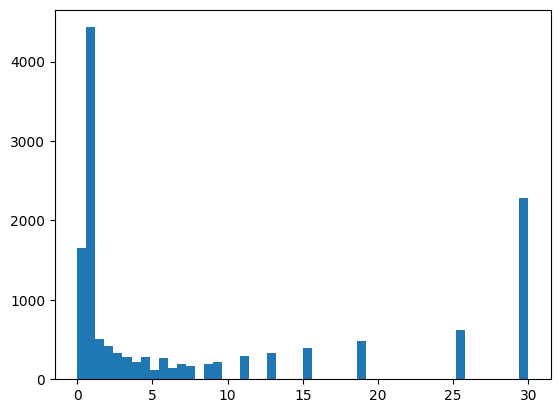

In [627]:
plt.hist(w3d.flatten(), bins=50)

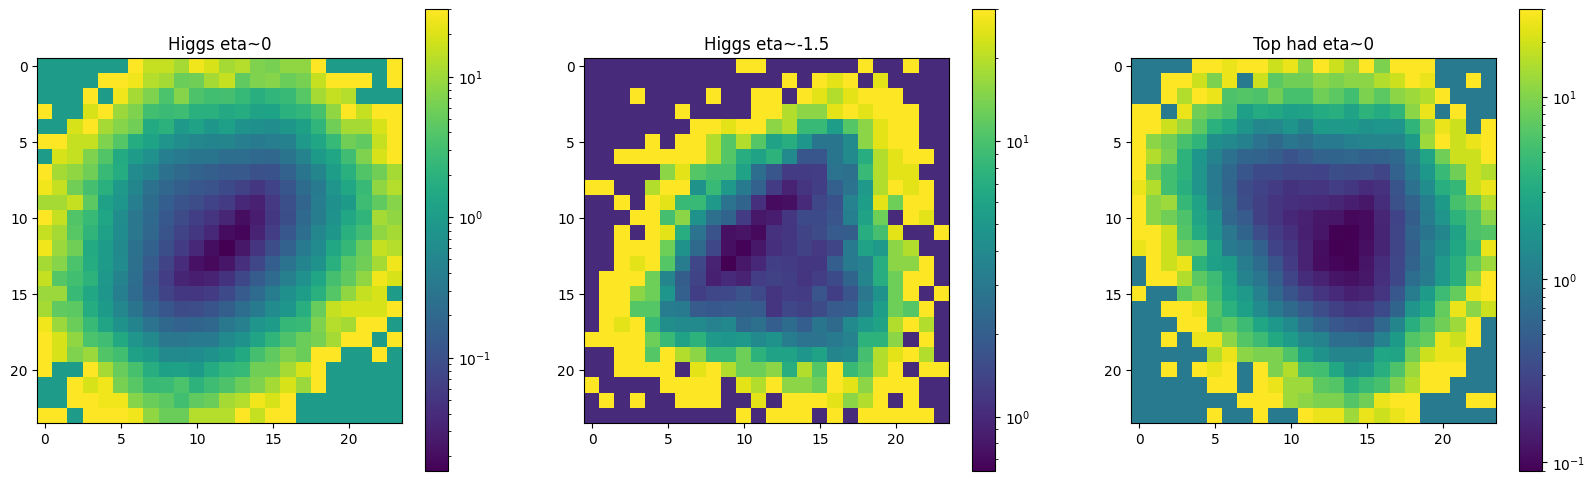

In [628]:
f, axs = plt.subplots(1, 3, figsize=(20, 6))

axs[0].set_title("Higgs eta~0")
I = axs[0].imshow(w3d[10,:,:],norm=LogNorm())
plt.colorbar(I, ax=axs[0])

axs[1].set_title("Higgs eta~-1.5")
I = axs[1].imshow(w3d[-5,:,:],norm=LogNorm())
plt.colorbar(I, ax=axs[1])

axs[2].set_title("Top had eta~0")
I = axs[2].imshow(w3d[:,7,:],norm=LogNorm())
plt.colorbar(I, ax=axs[2])

In [643]:
xind = np.digitize(higgs[:,1],  bins_h,  right=False)-1
yind = np.digitize(t[:,1], bins_t,       right=False)-1
zind = np.digitize(tbar[:,1], bins_tbar, right=False)-1

index = np.stack([xind, yind, zind], axis=1)

In [644]:
from numba import njit

@njit
def get_weight(weights, index):
    out = np.ones(len(index))
    i =0
    for a,b,c in index:
        #print(a,b,c)
        if (a<0) or a>=(Nbins-1) or (b<0) or b>=(Nbins-1) or (c<0) or c>=(Nbins-1):
            out[i] = 1.
        else:
            out[i] = weights[a, b, c]
        i+=1
    return out

In [645]:
w = get_weight(w3d, index)

In [632]:
np.isfinite(w3d.flatten()).sum() == (Nbins-1)**3

True

In [633]:
w

array([0.22689614, 0.26458131, 0.07467187, ..., 0.13138144, 2.06659459,
       0.11781818])

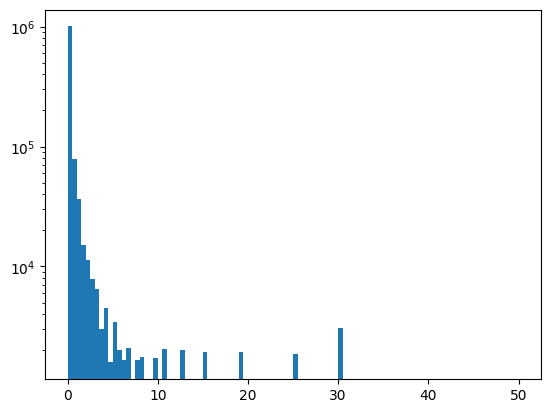

In [634]:
plt.hist(w, bins=100, range=(0, 50));
plt.yscale("log")

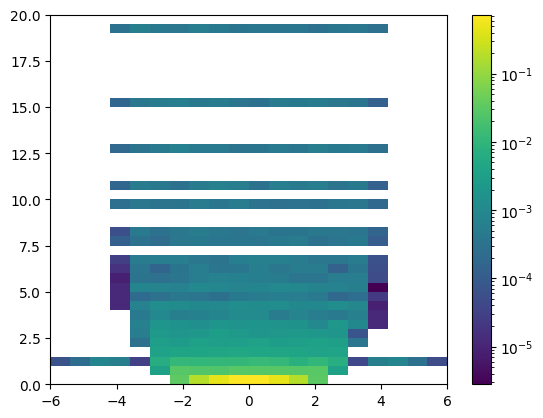

In [635]:
plt.hist2d(higgs[:,1], w, bins=(20,40), range=((-6,6), (0,20)), density=True, norm=LogNorm());
plt.colorbar()

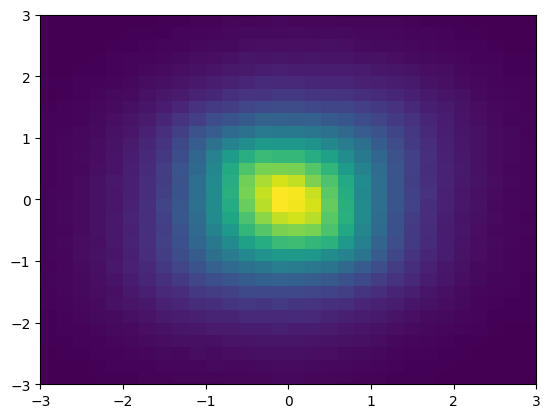

In [646]:
plt.hist2d(higgs[:,1], t[:,1], bins=30, range=((-3,3),(-3,3)));

(array([11107.152     , 16073.28      , 20541.944     , 23578.68      ,
        27258.272     , 30628.296     , 33701.104     , 35519.808     ,
        37091.728     , 37358.58400001, 37498.36800001, 38348.83200002,
        38191.22399998, 38212.904     , 37493.79999999, 36837.088     ,
        35195.24      , 33238.536     , 30869.616     , 27185.632     ,
        23058.04      , 19462.016     , 15439.424     , 11873.616     ]),
 array([-4.        , -3.66666667, -3.33333333, -3.        , -2.66666667,
        -2.33333333, -2.        , -1.66666667, -1.33333333, -1.        ,
        -0.66666667, -0.33333333,  0.        ,  0.33333333,  0.66666667,
         1.        ,  1.33333333,  1.66666667,  2.        ,  2.33333333,
         2.66666667,  3.        ,  3.33333333,  3.66666667,  4.        ]),
 [<matplotlib.patches.Polygon at 0x7f0d99abd910>])

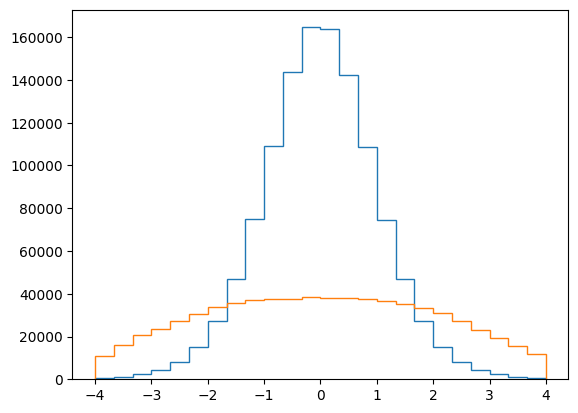

In [648]:
plt.hist(higgs[:,1], bins=bins_h, histtype="step")
plt.hist(higgs[:,1], bins=bins_h, weights=w, histtype="step")

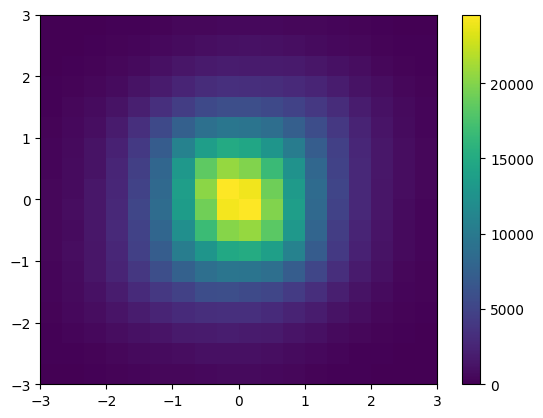

In [638]:
plt.hist2d(higgs[:,1], t[:,1], bins=[bins_h, bins_t]);
plt.xlim(-3,3)
plt.ylim(-3,3)
plt.colorbar()

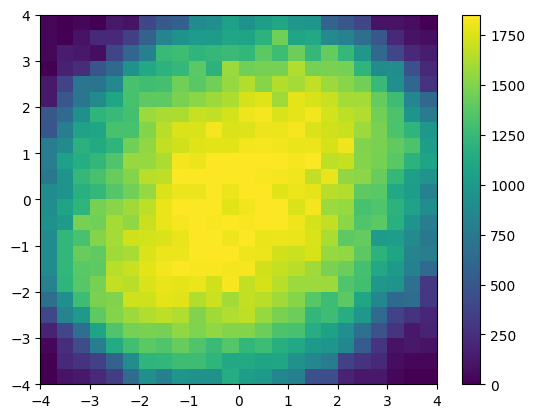

In [649]:
plt.hist2d(higgs[:,1], t[:,1], bins=[bins_h, bins_t], 
          weights=w);
plt.colorbar()

In [640]:
h_weighted = Hist(
    hist.axis.Variable( bins_h, name="h"),
    hist.axis.Variable( bins_t, name="t"),
    hist.axis.Variable( bins_tbar, name="tbar"),
    storage="Weight"
)
h_weighted.fill(higgs[:,1], t[:,1], tbar[:,1], weight=w)

Hist(
  Variable(array([-4.        , -3.66666667, -3.33333333, -3.        , -2.66666667,
       -2.33333333, -2.        , -1.66666667, -1.33333333, -1.        ,
       -0.66666667, -0.33333333,  0.        ,  0.33333333,  0.66666667,
        1.        ,  1.33333333,  1.66666667,  2.        ,  2.33333333,
        2.66666667,  3.        ,  3.33333333,  3.66666667,  4.        ]), name='h'),
  Variable(array([-4.        , -3.66666667, -3.33333333, -3.        , -2.66666667,
       -2.33333333, -2.        , -1.66666667, -1.33333333, -1.        ,
       -0.66666667, -0.33333333,  0.        ,  0.33333333,  0.66666667,
        1.        ,  1.33333333,  1.66666667,  2.        ,  2.33333333,
        2.66666667,  3.        ,  3.33333333,  3.66666667,  4.        ]), name='t'),
  Variable(array([-4.        , -3.66666667, -3.33333333, -3.        , -2.66666667,
       -2.33333333, -2.        , -1.66666667, -1.33333333, -1.        ,
       -0.66666667, -0.33333333,  0.        ,  0.33333333,  0.66666667,

In [641]:
h_weighted[:,sum,sum]

Hist(Variable(array([-4.        , -3.66666667, -3.33333333, -3.        , -2.66666667,
       -2.33333333, -2.        , -1.66666667, -1.33333333, -1.        ,
       -0.66666667, -0.33333333,  0.        ,  0.33333333,  0.66666667,
        1.        ,  1.33333333,  1.66666667,  2.        ,  2.33333333,
        2.66666667,  3.        ,  3.33333333,  3.66666667,  4.        ]), name='h'), storage=Weight()) # Sum: WeightedSum(value=695763, variance=6.93544e+06) (WeightedSum(value=696994, variance=6.93667e+06) with flow)

In [642]:
w

array([0.22689614, 0.26458131, 0.07467187, ..., 0.13138144, 2.06659459,
       0.11781818])

In [ ]:
`